In [188]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
import itertools
from sklearn.preprocessing import MinMaxScaler


In [189]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  

In [190]:
input_dim = 10
hidden_dim1 = 70
hidden_dim2 = 60
output_dim = 1
num_epochs = 15
batch_size = 64

In [191]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32)).float().to(device)
        self.y = torch.from_numpy(y.astype(np.float32)).float().to(device)
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [192]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim1)
        self.layer_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer_3 = nn.Linear(hidden_dim2, output_dim)
       
    def forward(self, x):
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = torch.sigmoid(self.layer_3(x))

        return x

In [193]:
trainingSet = pd.read_csv('../presentation/data/training.csv')
testingSet = pd.read_csv('../presentation/data/testing.csv')

In [194]:
# training data
x_train = trainingSet.iloc[:, :-1].values  # features
y_train = trainingSet.iloc[:, -1].values  # labels
x_test = testingSet.iloc[:, :-1].values  # features
y_test = testingSet.iloc[:, -1].values  # labels

In [195]:
scaler = MinMaxScaler(copy=True, feature_range=(0,1))
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [196]:
train_data = Data(x_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

test_data = Data(x_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [197]:
model = NeuralNetwork(input_dim, hidden_dim1, hidden_dim2, output_dim)
model = model.to(device)

In [198]:
learning_rate = 0.001

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters())

In [199]:
loss_values = np.array([])


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values = np.append(loss_values,loss.item())
        loss.backward()
        optimizer.step()
    print(f'Epoch num {epoch}')
    print("--------------------------")

print("Training Complete")

Epoch num 0
--------------------------
Epoch num 1
--------------------------
Epoch num 2
--------------------------
Epoch num 3
--------------------------
Epoch num 4
--------------------------
Epoch num 5
--------------------------
Epoch num 6
--------------------------
Epoch num 7
--------------------------
Epoch num 8
--------------------------
Epoch num 9
--------------------------
Epoch num 10
--------------------------
Epoch num 11
--------------------------
Epoch num 12
--------------------------
Epoch num 13
--------------------------
Epoch num 14
--------------------------
Training Complete


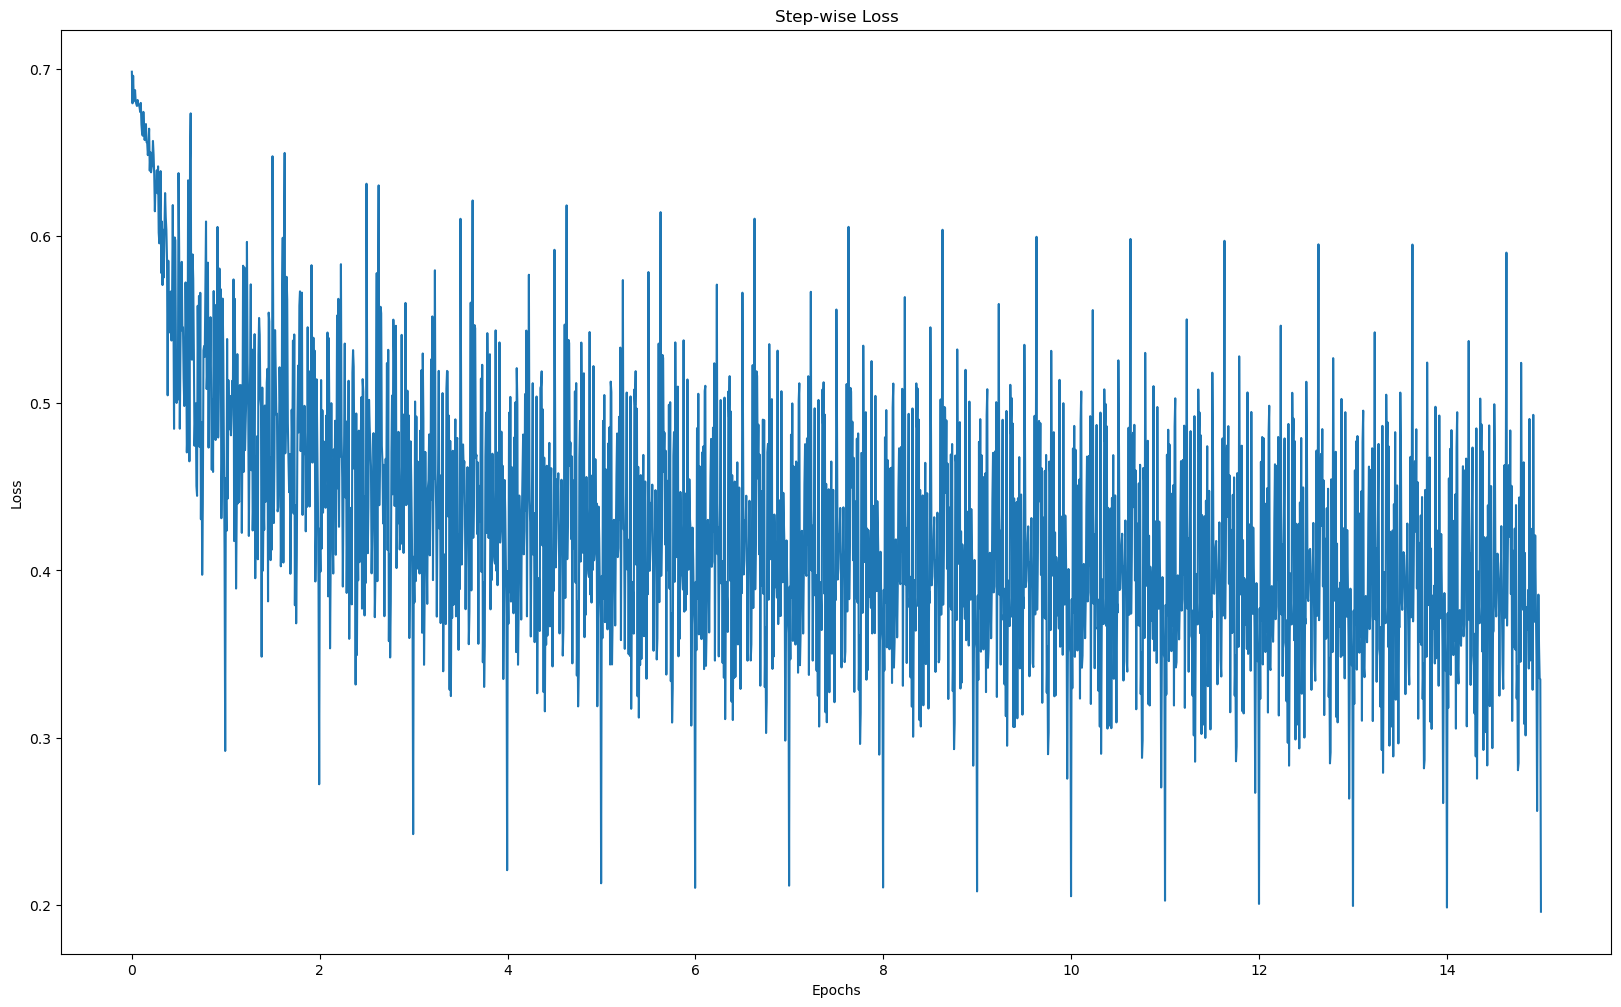

In [200]:
step = np.linspace(0, num_epochs, loss_values.shape[0])

fig, ax = plt.subplots(figsize=(20,12))
plt.plot(step,loss_values)
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [201]:
num_correct = 0
num_samples = 0
y_pred = np.array([])

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        predicted = np.where(outputs.cpu().data.numpy() <= 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred = np.append(y_pred,predicted)

#         y = list(itertools.chain(*y))

#         print(y)
#         _,p = predicted.max(1)
#         print(y.size())
#         print(predicted.data[:,-1])
#         print(y.data)
        num_correct += (predicted == y.cpu().data.numpy()).sum().item()
        num_samples += y.size(0)
print(f'Correct = {num_correct} and total = {num_samples} then accuracy = {100* num_correct // num_samples}%')

Correct = 3321 and total = 4012 then accuracy = 82%


              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2006
           1       0.82      0.84      0.83      2006

    accuracy                           0.83      4012
   macro avg       0.83      0.83      0.83      4012
weighted avg       0.83      0.83      0.83      4012

Precesion score = 81.99513381995133%


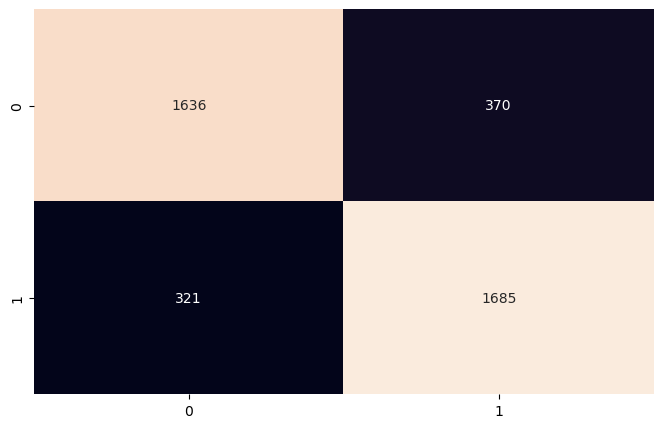

In [202]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score

import seaborn as sns

# y_pred = list(itertools.chain(iter(y_pred)))
# y_test = list(itertools.chain(iter(y_test)))

# y_pred = y_pred[0:-1]
print(classification_report(torch.from_numpy(y_test), torch.from_numpy(y_pred)))

cf_matrix = confusion_matrix(y_test, y_pred)
pre = precision_score(y_test, y_pred)
print(f'Precesion score = {100*pre}%')
plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.show()